<font size = +2.5><center><u><b>Suicide Risk Detection Model for Mental Health Chatbots</b></u></center></font>

<h2><i><center>Data Exploration (Suicide_Detection.csv)</center></i></h2>

---

### Source:
**Suicide and Depression Dataset** from Kaggle
https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch


### About:
* The dataset is a collection of posts from "SuicideWatch" and "depression" subreddits of the Reddit platform. 
    * Posts were collected using Pushshift API. 
* "SuicideWatch" posts from Dec 16, 2008 (creation) till Jan 2, 2021
* "Depression" posts were collected from Jan 1, 2009, to Jan 2, 2021.

# I. Data Cleaning

### Data Cleaning Packages and Imports

In [1]:
'''Python Standard Packages'''
import re
import string
import time

'''Conda Standard Packages'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

'''learn-env standard packages'''
import seaborn as sns
import nltk
from nltk import FreqDist
#from nltk.corpus import stopwords, words

'''Used in Data Cleaning'''
import contractions
from textacy import preprocessing as preproc

from spellchecker import SpellChecker #PySpellChecker
from symspellpy import SymSpell #SymSpell

'''For Iterable Time Tracking'''
from tqdm import tqdm
tqdm.pandas()

## Dataset - First Look

In [ ]:
# Importing Dataset for the first time

df = pd.read_csv("./data/Suicide_Detection.csv")
df.head()

In [ ]:
# Dropping arbitrary "ID" column

df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df["class"].value_counts()

In [ ]:
# Example of suicide post:

df.loc[0].text

In [ ]:
# Example of non-suicide post:

df.loc[1].text

## Describing Dataset

* n = 232,074
* Binary Classification (Suicide vs. Non-Suicide), each n = 116037 (50/50 split)

## Text Pre-Processing

### 1.1 Quick Function to Find and Remove Spam:

In [ ]:
def char_counter(string):
    charCount = {"alnum": 0, "not_alnum": 0}
    accepted = " '"
    for char in string:
        if char.isalnum() or char in accepted:
            charCount["alnum"] += 1
        else:
            charCount["not_alnum"] += 1
    if charCount["not_alnum"] > charCount["alnum"]:
        return 0
    else:
        return string

In [ ]:
df["text_trial"] = df["text"].apply(lambda x: char_counter(x))

df = df[df["text_trial"] != 0]

df = df.drop(["text_trial"], axis=1)

In [ ]:
print(f"CharCounter Removed {232074 - 231307} spam data points")

### 1.2 Removing Unrecognized \n and & characters

In [ ]:
df["textprep"] = df["text"].apply(lambda x: re.sub(r"\n&\S+", "", x))

In [ ]:
df["textprep"] = df["textprep"].apply(lambda x: re.sub(r"\n", "", x))

In [ ]:
df["textprep"] = df["textprep"].apply(lambda x: re.sub("&lt", "", x))

In [ ]:
df["textprep"] = df["textprep"].apply(lambda x: re.sub("&gt", "", x))

In [ ]:
df["textprep"]

### 1.3 Removing usernames (format: u/name)

In [ ]:
df["textprep"] = df["textprep"].apply(lambda x: re.sub(r"u/\w+", "", x))

### 1.4 Removing numbers and strings starting with numbers

In [ ]:
# 4. Remove Numbers and nth
df["textprep"] = df["textprep"].apply(lambda x: re.sub(r"\d\S+", "", x))
df["textprep"] = df["textprep"].apply(lambda x: re.sub(r"\d+", "", x))

### 1.5 Remove Website Links

In [ ]:
df["textprep"] = df["textprep"].apply(lambda x: re.sub(r"htt\S+", "", x))
df["textprep"] = df["textprep"].apply(lambda x: re.sub(r"ww\S+", "", x))

### 1.6 Removing Accents, Brackets, Hmtl_Tags, and Unicode (Emojis)

In [ ]:
# 40 seconds to run

start = time.time()

pipe = preproc.make_pipeline(
    preproc.normalize.hyphenated_words,
    preproc.normalize.quotation_marks,
    preproc.remove.accents,
    preproc.remove.brackets,
    preproc.remove.html_tags,
)

df["textprep"] = df["textprep"].apply(lambda x: pipe(x))

end = time.time()

In [ ]:
def remove_unicode(string):
    str_en = string.encode("ascii", "ignore")
    str_de = str_en.decode()
    return str_de


df["text"] = df["text"].apply(lambda x: remove_unicode(str(x)))

### 1.7 Removing Punctuation

In [ ]:
# No Punctuation
df["textprep"] = df["textprep"].apply(
    lambda x: x.translate(str.maketrans("", "", string.punctuation))
)

### 1.8 Splitting wordsStrungTogetherLikeThis

In [ ]:
df["textprep"] = df["textprep"].apply(
    lambda x: re.sub(r"(?<![A-Z\W])(?=[A-Z])", " ", x)
)

### 1.9 Normalize Whitespace

In [ ]:
# Lowercase
# df['textprep'] = df['textprep'].apply(lambda x: x.lower())

# Normalize Whitespace
df["textprep"] = df["textprep"].apply(lambda x: preproc.normalize.whitespace(x))

In [ ]:
df["textprep"]

### 1.10 Lowercase All

In [ ]:
df["textprep"] = df["textprep"].apply(lambda x: x.lower())

---

## 2. Expand contractions, Append prefixes, and correct "wordi"s 

### 2.1 Expand Contractions

* Using Contractions Library (https://pypi.org/project/contractions)

In [ ]:
df["textprep"] = df["textprep"].apply(lambda x: contractions.fix(x))

In [ ]:
df["textprep"]

### 2.2 Remove Quotation Marks and Apostrophes

In [ ]:
df["textprep"] = df["textprep"].apply(lambda x: preproc.remove.punctuation(x))

### 2.3 Append prefix to previous word

* To tell spaCy "anti" is a prefixes, let's append with hyphen for now. We can correct later for models that cannot handle hyphens.

* Join "Mc" and "Pre" with word

In [ ]:
# Anti
df["textprep"] = df["textprep"].apply(lambda x: re.sub(r" (anti) (\S+)", r" \1-\2", x))
df["textprep"] = df["textprep"].apply(lambda x: re.sub(r" (anti)(\S+)", r" \1-\2", x))

# Pre
# df['textprep']=df['textprep'].apply(lambda x: re.sub(r' (pre) (\S+)', r' \1\2', x))

# Mc
df["textprep"] = df["textprep"].apply(lambda x: re.sub(r" (mc) (\S+)", r" \1\2", x))

In [ ]:
df["textprep"] = df["textprep"].apply(lambda x: re.sub(r" (anti)--(\S+)", r" \1-\2", x))

### 2.4 Wordi Correction

* Lots of typos where i is appended to word where it shouldn't be. 
* Created a function to fix this using spellchecker and re

In [ ]:
spell = SpellChecker()

In [ ]:
def wordi_corrector(row):
    spell = SpellChecker()
    for word in re.findall(r"\b\S+i\b", row):
        if spell.known([word]):
            continue
        tester = word[:-1]
        if len(spell.known([tester])) == 1:
            row = re.sub(word, tester + " i", row)
    return row

In [ ]:
df["test"] = df["textprep"].progress_map(lambda x: wordi_corrector(x))

### 2.5 Create Tokens from TextPrep

In [ ]:
df["tokens"] = df["textprep"].apply(lambda x: x.split())

## 3. Find Common Misspelled Words & Translate Slang

### Testing SpellChecker

In [ ]:
start = time.time()

spell = SpellChecker()
df["misspell"] = df["tokens"].apply(lambda x: spell.unknown(x))
df["misspell"] = df["misspell"].apply(lambda x: list(x))

end = time.time()

print(f"Time to run: {end - start:.2f} seconds")

In [ ]:
df["misspell_length"] = df["misspell"].apply(lambda x: len(x))

percent_wrong = len(df["misspell"][df["misspell_length"] != 0]) / len(df) * 100

print(f"{percent_wrong:.1f}% of datapoints have misspellings")

In [ ]:
sperror_master = []

for row in df["misspell"]:
    for word in row:
        sperror_master.append(word)

In [ ]:
fd1 = FreqDist(sperror_master)
fd1.most_common(20)

In [ ]:
df["text"] = df["text"].apply(lambda x: re.sub("selfharm", "self-harm", x))

In [ ]:
df["text"] = df["text"].apply(lambda x: re.sub(" bs ", " bullshit ", x))

---

### Steps

1. Remove single letter tokens and remaining code fragments (ex: \x...)
2. Separate out words that should have spaces in them (word_i)
3. Dictionary
   * Convert slang words to commonly used equivalent
   * For some slang-- like tldr, wtf, ngl, omg-- full equivalent doesn't really make sense. Have dictionary recognize these as words.
   * Add words like "covid", "antidepressant (+ antidepressant names)" to dictionary


### Round 1: Removing Single Tokens + Expanding Abbrevations of Common Words

In [ ]:
""" 1. Remove single letter tokens and remaining code fragments"""

single_token_list = []
for item in fd1:
    if not bool(emoji.emoji_count(item[0])):
        if len(item[0]) == 1 and item[0] not in single_token_list:
            single_token_list.append(item[0])

single_token_list.remove("a")
single_token_list.remove("i")

In [ ]:
single_token_list

In [ ]:
def single_token_remover(row, token_list):
    for token in row:
        if token in token_list:
            row.remove(token)
    return row

In [ ]:
df["tokens_r2"] = df["tokens"].progress_map(
    lambda x: single_token_remover(x, single_token_list)
)

In [ ]:
# df['tokens_r2'] = df['tokens_r2'].apply(lambda x: (' '.join(x)).split())

In [ ]:
df["tokens_r2"]

In [ ]:
df

In [ ]:
df["text_r2"] = df["tokens_r2"].progress_map(lambda x: " ".join(x))

---

### Round 2: Correction dictionary & correcting SpellChecker

#### 3.2.1. Distinguishing between ECT (etc misspelled) and ECT (therapy)
1. Got indices based on capitalization in original text
2. went through lowercase ect examples and found 7 referring to therapy
3. Replaced ect in ect_ther with electroconvulsive therapy, 
4. changing to correct spelling of etc elsewhere

In [ ]:
ect_ther = (
    df["text"]
    .apply(lambda x: re.findall(r" ECT ", x))
    .sort_values(ascending=False)[:72]
    .index
)

In [ ]:
ect_ther.extend([12935, 181494, 21986, 189017, 49323, 78657, 205774])

In [ ]:
df["text_r2"][ect_ther] = df["text_r2"][ect_ther].apply(
    lambda x: re.sub(r" ect ", " electroconvulsive therapy ", x)
)

In [ ]:
df["text_r2"] = df["text_r2"].apply(lambda x: re.sub(r" ect ", r" etc ", x))

In [ ]:
# Changing Back because typing out electroconvulsive therapy much less likely than ect

df["text_r2"] = df["text_r2"].apply(
    lambda x: re.sub(r"electroconvulsive therapy", "ect", x)
)

#### 3.2.2 Replacing 'tl dr' with 'tldr'

In [ ]:
df["text_r2"] = df["text_r2"].apply(lambda x: re.sub(r" tl dr ", r" tldr ", x))

In [ ]:
df["tokens_r2"] = df["text_r2"].apply(lambda x: x.split())

#### 3.3.3 Replacement Dictionary and adding words to SpellCheck

In [ ]:
"""3. Create replacement dictionary"""

slang_dictionary = {
    "dr": "doctor",
    "gf": "girlfriend",
    "dm": "message",
    "pm": "message",
    "tv": "television",
    "plz": "please",
    "pls": "please",
    "bf": "boyfriend",
    "pc": "computer",
    "dms": "messages",
    "wtf": "what the fuck",
    "tf": "the fuck",
    "irl": "in real life",
    "lmao": "haha",
    "lol": "haha",
    "rofl": "haha",
    "bruh": "bro",
    "thru": "through",
    "idek": "idk",
    "idk": "i do not know",
    "idc": "i do not care",
    "smdh": "smh",
    "coronavirus": "covid",
    "yknow": "you know",
    "kms": "kill myself",
    "fr": "for real",
    "lbs": "pounds",
    "vs": "versus",
    "mr": "mister",
    "crysis": "crisis",
    "everytime": "every time",
    "alot": "a lot",
    "noone": "nobody",
    "andor": "and or",
    "familys": "family",
    "todays": "today",
    "aswell": "as well",
    "lastname": "last name",
    "firstname": "first name",
    "growup": "grow up",
    "loosing": "losing",
    "redditors": "redditor",
    "subreddits": "subreddit",
    "ng": "not good",
    "nnn": "",
    "romanti": "romantic",
    "mg": "milligrams",
    "hs": "high school",
    "nsfw": "not safe for work",
    "asf": "as fuck",
    "hmu": "message me",
    "ngl": "not going to lie",
    "omg": "oh my god",
    "welp": "well",
    "lgbt": "lgbtq",
    "quaranti": "quarantine",
    "lowkey": "low key",
    "pedos": "pedophiles",
    "smth": "something",
    "bestfriend": "best friend",
    "commiting": "committing",
    "ffs": "for fuck sake",
    "selfharming": "self-harm",
    "untill": "until",
    "downvoted": "downvote",
    "selfloathing": "self-loathing",
    "ideations": "ideation",
    "gp": "doctor",
    "jk": "just kidding",
    "tommorow": "tomorrow",
    "meanti": "meant i",
    "aight": "alright",
    "exes": "ex",
    "fml": "fuck my life",
    "mf": "motherfucker",
    "selfhatred": "self-hatred",
    "selfesteem": "self-esteem",
    "tw": "trigger warning",
    "idek": "i do not know",
    "fcking": "fuck",
    "commited": "committed",
    "oding": "overdose",
    "od": "overdose",
    "oded": "overdose",
    "cringey": "cringe",
    "yk": "you know",
    "uhh": "uh",
    "parttime": "part time",
    "cmon": "come on",
    "exgirlfriend": "ex",
    "happend": "happened",
    "fck": "fuck",
    "hrs": "hours",
    "becuase": "because",
    "blm": "black lives matter",
    "hr": "hour",
    "gfs": "girlfriend",
    "yalls": "you all",
    "fb": "facebook",
    "wierd": "weird",
    "dosent": "does not",
    "sht": "shit",
    "selfdestructive": "self-destructive",
    "payed": "paid",
    "aa": "alcoholics anonymous",
    "ssris": "ssri",
    "snris": "snri",
    "wich": "which",
    "hw": "homework",
    "lmfao": "haha",
    "havnt": "have not",
    "franti": "frantic",
    "afterward": "afterwards",
    "selfworth": "self-worth",
    "freinds": "friends",
    "pt": "patient",
    "daynight": "day night",
    "acc": "according",
    "inbetween": "in between",
    "sooooo": "so",
    "thicc": "thick",
    "meim": "me i am",
    "lil": "little",
    "uwu": "cute",
    "gc": "group chat",
    "helphey": "help hey",
    "friendzoned": "friend zoned",
    "uhhh": "uh",
    "selfharmed": "self-harm",
    "nyc": "new york city",
    "deadend": "dead end",
    "belive": "believe",
    "gn": "good night",
    "dissapointment": "disappointment",
    "exboyfriend": "ex",
    "ll": "i will",
    "nhs": "national health service",
    "spamming": "spam",
    "existance": "existence",
    "monke": "monkey",
    "advil": "medication",
    "downvotes": "downvote",
    "countrys": "country",
    "ldr": "long distance relationship",
    "selfconfidence": "self-confidence",
    "mebut": "me but",
    "pokmon": "pokemon",
    "socalled": "so called",
    "itim": "it i am",
    "realy": "really",
    "neet": "neat",
    "daytoday": "day today",
    "psa": "public service announcement",
    "dd": "dungeons and dragons",
    "gcses": "high school",
    "clich": "cliche",
    "reddits": "reddit",
    "sucide": "suicide",
    "depressionanxiety": "depression anxiety",
    "thier": "their",
    "lmk": "let me know",
    "itbut": "it but",
    "incels": "incel",
    "selfconscious": "self-conscious",
    "urself": "yourself",
    "litterally": "literally",
    "shitposting": "spam",
    "layed": "laid",
    "heshe": "he she",
    "septemberbeginning": "september beginning",
    "corna": "covid",
    "expiernce": "experience",
    "arnt": "are not",
    "apperently": "apparently",
    "inperson": "in person",
    "instaead": "instead",
    "waht": "what",
    "vc": "video chat",
    "acciddently": "accidentally",
    "sence": "sense",
    "bfs": "boyfriend",
    "helpjust": "help just",
    "sertaline": "sertraline",
    "lifebut": "life but",
    "afraidanxious": "afraid anxious",
    "urself": "yourself",
    "litterally": "literally",
    "paat": "past",
}

In [ ]:
spell.word_frequency.load_words(
    [
        "sertraline",
        "zoloft",
        "fluoxetine",
        "prozac",
        "citalopram",
        "celexa",
        "escitalopram",
        "lexapro",
        "paroxetine",
        "paxil",
        "bupropion",
        "wellbutrin",
        "seroquel",
        "ect",
        "cbt",
        "dbt",
        "ptsd",
        "adhd",
        "selfharm",
        "bpd",
        "ssri",
        "snri",
        "snri",
        "aspergers",
        "dysphoria",
        "anti-depressant",
        "anti-depressants",
        "dysmorphia",
        "hrt",
        "cps",
        "mdd",
    ]
)

In [ ]:
spell.word_frequency.load_words(
    [
        "subreddit",
        "redditor",
        "rteenagers",
        "rdepression",
        "rsuicidewatch",
        "csgo",
        "minecraft",
        "gta",
        "fortnite",
        "roblox",
        "mcworld",
        "mcdonalds",
        "walmart" "tldr",
        "bs",
        "omg",
        "smh",
        "ps",
        "lgbtq",
        "sw",
        "afterwards",
        "afterlife",
        "transphobic",
        "yourselves",
        "afternoon",
        "covid",
        "tiktok",
        "dysphoria",
        "spotify",
        "anti-depressant",
        "yourselves",
        "downvote",
        "insta",
        "incel",
        "femboy",
        "aftermath",
        "hentai",
        "repost",
        "nonbinary",
        "pms",
        "lsd",
        "hmm",
        "microsoft",
        "tumblr",
        "snoo",
        "femboys",
        "weeb",
        "screenshots",
        "omegle",
        "youtuber",
        "unironically",
        "tldr",
    ]
)

In [ ]:
def token_replacer(row, slang_dictionary):
    new_row = []
    for word in row:
        if word in slang_dictionary.keys():
            new_row.append(slang_dictionary[word])
        else:
            new_row.append(word)
    return new_row

In [ ]:
df["tokens_r3"] = df["tokens_r3"].apply(lambda x: token_replacer(x, slang_dictionary))
df["text_r3"] = df["tokens_r3"].apply(lambda x: (" ".join(x)))
df["tokens_r3"] = df["text_r3"].apply(lambda x: x.split())

In [ ]:
df

In [ ]:
df.drop(["tokens", "tokens_r2", "text_r2"], axis=1, inplace=True)

---

### Round 3: Rinse & Repeat til less than 250 spelling errors per word

In [ ]:
# df['text_r3'] = df['tokens_r3'].apply(lambda x: (' '.join(x)))
# df['tokens_r3'] = df['text_r3'].apply(lambda x: x.split())

In [ ]:
df["misspell"] = df["tokens_r3"].map(lambda x: spell.unknown(x))
df["misspell"] = df["misspell"].map(lambda x: list(x))

In [ ]:
sperror_master = []

for row in df["misspell"]:
    for word in row:
        sperror_master.append(word)

In [ ]:
fd = FreqDist(sperror_master)

fd.most_common(20)

In [ ]:
def token_remover(row_list, token_list):
    for token in token_list:
        if token in row_list:
            row_list.remove(token)
    return row_list

In [ ]:
tokens_to_remove = ["pp", "cs", "ph", "th", "ds", "st", "yt"]
df["tokens_r3"] = df["tokens_r3"].apply(lambda x: token_remover(x, tokens_to_remove))

In [ ]:
char = fd.most_common(20)[16][0]
df['tokens_r3'] = df['tokens_r3'].apply(lambda x: token_remover(x, ['\u200d'))
df['tokens_r3'] = df['tokens_r3'].apply(lambda x: token_remover(x, char))

In [ ]:
dict2 = {
    "anymorei": "anymore i",
    "exs": "exes",
    fd.most_common(20)[19][0]: "",
    "pedo": "pedophile",
}

In [ ]:
df["tokens_r3"] = df["tokens_r3"].apply(lambda x: token_replacer(x, dict2))
df["text_r3"] = df["tokens_r3"].apply(lambda x: (" ".join(x)))
df["tokens_r3"] = df["text_r3"].apply(lambda x: x.split())

---

There are too many spelling errors to go through and completely clean. 
Especially since Text2Emotion has its own cleaning process-- we can come back to the cleaning process after running Text2Emotion
(and getting rid of emojis will help/running the no unicode code will help)

In [ ]:
# df.drop(['text', 'textprep', 'misspell'], axis=1, inplace=True)
# df = df.rename({'tokens_r3':'tokens', 'text_r3':'text'}, axis=1)
df.to_csv("./data/data_cleaned.csv")

---

### Round 4: Autocorrect words, Remove "Filler" text, and get rid of hyphens

In [14]:
""" Autocorrect - doesn't do much """

# spell = Speller(fast=True)
# df['text'] = df['text'].progress_map(lambda x: spell(str(x)))'''

In [66]:
# Remove filler words/letters/phrases

df["text"] = df["text"].apply(
    lambda x: re.sub(r"filler", "", x), lambda x: re.sub(r"zz\S+", "", x)
)

In [67]:
# No more spaCy = no more hyphens

df["text"] = df["text"].apply(
    lambda x: re.sub(r" (anti)-(\S+)", " \1\2", x), lambda x: re.sub(r"-", "", x)
)

#### Round 5: Trying SymSpell (Not used: No DF edits)

In [9]:
from itertools import islice

import pkg_resources

sym_spell = SymSpell()
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, 0, 1)

print(list(islice(sym_spell.words.items(), 5)))

[('the', 23135851162), ('of', 13151942776), ('and', 12997637966), ('to', 12136980858), ('a', 9081174698)]


In [10]:
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
sym_spell.load_bigram_dictionary(dictionary_path, 0, 2)

# Print out first 5 elements to demonstrate that dictionary is
# successfully loaded
print(list(islice(sym_spell.bigrams.items(), 5)))

[('abcs of', 10956800), ('aaron and', 10721728), ('abbott and', 7861376), ('abbreviations and', 13518272), ('aberdeen and', 7347776)]


In [31]:
""" Need to add my dictionary terms before this is useful

def sym_spell_check(input_term):
    
    suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)
    for suggestion in suggestions:
        return suggestion.term
        
"""

---

# ~ Save Processed DF to CSV ~

In [3]:
df.to_csv("./data/data_cleaned.csv")

NameError: name 'df' is not defined

# Data Modeling

## Import Packages

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as Lem
from nltk.tokenize import word_tokenize
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from src.confusion import plot_confusion_matrix

## Model Plan



**Frequency Vectorization** - *TF-IDF*

**Emotion Analysis & Scoring** - *NRCLex*
   * Two publicly accessible options: NRCLex and Text2Emotion 
   * [Recent study](https://www.mdpi.com/2076-3417/13/4/2061) found NRCLex to be more accurate and have more classes (Fargues, Kadry, Lawal, Yassine & Rauf, 2023).
   * Also, NRCLex is [faster](https://medium.com/@aeshnagupta/5-methods-to-do-emotion-analysis-on-text-data-98cf662efc12)
---

### Model Iterations
 1. Naive Bayes
- [x] TF-IDF only - **FSM**
- [ ] NRCLex only
- [ ] Both TF-IDF and NRCLex

 2. Random Forest Classifier
- [ ] Both TF-IDF and NRCLex
- [ ] Top Features

 3. SVM
- [ ] Both TF-IDF and NRCLex

4. Tuned Final Model
- [ ] Best

## 1. Pre-Processing in Post

### 1.1 Load saved processed data from csv

In [3]:
## Saved Data has all of the above preprocessing corrections run up until now.

df = pd.read_csv("./data/data_cleaned.csv")
df["text"] = df["text"].map(lambda x: str(x))

In [4]:
df

,Unnamed: 0,index,class,text
0,0,0,suicide,ex wife threatening suicide recently i left my...
1,1,1,non-suicide,am i weird i do not get affected by compliment...
2,2,2,non-suicide,finally is almost over so i can never hear has...
3,3,3,suicide,i need help just help me i am crying so hard
4,4,4,suicide,i am so lost hello my name is adam and i have ...
...,...,...,...,...
231302,231302,232069,non-suicide,if you do not like rock then your not going to...
231303,231303,232070,non-suicide,you how you can tell i have so many friends an...
231304,231304,232071,non-suicide,pee probably tastes like salty tea can someone...
231305,231305,232072,suicide,the usual stuff you find here i am not posting...


In [5]:
df.drop(["Unnamed: 0", "index"], axis=1, inplace=True)
df["text"].progress_apply(lambda x: str(x))
df

100%|██████████| 231307/231307 [00:00<00:00, 2085740.74it/s]


,class,text
0,suicide,ex wife threatening suicide recently i left my...
1,non-suicide,am i weird i do not get affected by compliment...
2,non-suicide,finally is almost over so i can never hear has...
3,suicide,i need help just help me i am crying so hard
4,suicide,i am so lost hello my name is adam and i have ...
...,...,...
231302,non-suicide,if you do not like rock then your not going to...
231303,non-suicide,you how you can tell i have so many friends an...
231304,non-suicide,pee probably tastes like salty tea can someone...
231305,suicide,the usual stuff you find here i am not posting...


### 1.2. Convert Target to Binary Variable

In [6]:
df["target"] = df["class"].replace({"non-suicide": 0, "suicide": 1})

In [7]:
# df = df.reset_index()
df.drop(["class"], axis=1, inplace=True)

In [8]:
df

,text,target
0,ex wife threatening suicide recently i left my...,1
1,am i weird i do not get affected by compliment...,0
2,finally is almost over so i can never hear has...,0
3,i need help just help me i am crying so hard,1
4,i am so lost hello my name is adam and i have ...,1
...,...,...
231302,if you do not like rock then your not going to...,0
231303,you how you can tell i have so many friends an...,0
231304,pee probably tastes like salty tea can someone...,0
231305,the usual stuff you find here i am not posting...,1


### 1.3 Tokenize, Lemmatize, and re-join

In [12]:
df["tokens"] = df["text"].apply(lambda s: word_tokenize(s))

In [13]:
lem = Lem()

In [14]:
df["tokens"] = df["tokens"].apply(lambda x: [lem.lemmatize(token) for token in x])

In [15]:
df["text"] = df["tokens"].apply(lambda x: str(" ".join(x)))

In [16]:
df.drop(["tokens"], axis=1, inplace=True)

### 1.4 Remove StopWords with spaCy (try with + without)

In [17]:
""" Load SpaCy"""

# Using 'en_core_web_sm' Dictionary
import time

import spacy

nlp = spacy.load("en_core_web_sm")
import en_core_web_sm

nlp = en_core_web_sm.load()

from spacytextblob.spacytextblob import SpacyTextBlob

* Setting up a separate dataframe to compare with spaCy stopword removal vs. without

In [18]:
""" Remove stopwords from nostop_df """

nostop_df = df.copy()
stopwords = nlp.Defaults.stop_words
nostop_df["text"] = nostop_df["text"].apply(
    lambda x: " ".join([word for word in str(x).split() if word not in (stopwords)])
)

## 2a. Setting up Emotion Detection Dataset - StopWords Included

In [99]:
# pip install NRCLex

from nrclex import NRCLex

In [23]:
# Testing how NRCLex Works

emotion = NRCLex(
    "I have this thing where I get older but just never wiser, midnights become my afternoons. \
When my depression works the graveyard shift, all of the people I've ghosted stand in the room."
)

print(emotion.affect_list)

print("\n", emotion.affect_dict)

print("\n", emotion.raw_emotion_scores)

print("\n", emotion.top_emotions)

print("\n", emotion.affect_frequencies)

tester = pd.DataFrame([emotion.affect_frequencies])


# emotion = NRCLex("'am i weird i do not get affected by compliments if its coming from someone i know in real life but i feel really good when internet strangers do it")
# emotion.raw_emotion_scores

['sadness', 'negative', 'sadness']

 {'older': ['sadness'], 'depression': ['negative', 'sadness']}

 {'sadness': 2, 'negative': 1}

 [('sadness', 0.6666666666666666)]

 {'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 'trust': 0.0, 'surprise': 0.0, 'positive': 0.0, 'negative': 0.3333333333333333, 'sadness': 0.6666666666666666, 'disgust': 0.0, 'joy': 0.0}


In [34]:
""" Make an affect_df to concat with df"""

total_text = [text for text in df["text"]]

emot_df = pd.DataFrame()

for text in tqdm(total_text):
    emot_map = NRCLex(text).raw_emotion_scores
    row_pt2 = pd.DataFrame([emot_map])
    emot_df = pd.concat([emot_df, row_pt2], ignore_index=True)

emot_df

100%|██████████| 231307/231307 [05:00<00:00, 769.87it/s]


,anger,disgust,fear,negative,sadness,anticipation,joy,positive,surprise,trust
0,9.0,5.0,9.0,12.0,7.0,7.0,5.0,5.0,5.0,5.0
1,NaN,1.0,1.0,2.0,NaN,3.0,2.0,3.0,2.0,3.0
2,2.0,2.0,2.0,2.0,1.0,2.0,2.0,3.0,1.0,3.0
3,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,21.0,13.0,30.0,40.0,29.0,26.0,9.0,15.0,8.0,13.0
...,...,...,...,...,...,...,...,...,...,...
231302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
231303,1.0,1.0,2.0,2.0,1.0,NaN,1.0,2.0,NaN,2.0
231304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231305,9.0,6.0,7.0,14.0,10.0,3.0,2.0,7.0,1.0,4.0


In [20]:
df

# Emot_df has same Indices and No. Rows as df! Good!

,text,target
0,ex wife threatening suicide recently i left my...,1
1,am i weird i do not get affected by compliment...,0
2,finally is almost over so i can never hear ha ...,0
3,i need help just help me i am cry so hard,1
4,i am so lost hello my name is adam and i have ...,1
...,...,...
231302,if you do not like rock then your not going to...,0
231303,you how you can tell i have so many friend and...,0
231304,pee probably taste like salty tea can someone ...,0
231305,the usual stuff you find here i am not posting...,1


In [35]:
# NaN values should be 0.0 but they were skipped over- replace with 0.0

emot_df = emot_df.mask(emot_df.isna(), 0)

In [36]:
emot_df.isna().sum()

anger           0
disgust         0
fear            0
negative        0
sadness         0
anticipation    0
joy             0
positive        0
surprise        0
trust           0
dtype: int64

**EMOTION SCORES**

  * NRCLex has two quantitative components: raw emotion scores and affective frequencies
     * Raw emotion scores: count vectorizor of emotion-coded words vs. affective frequencies = percentage of each category in each text.
  * Affective frequencies were off mathematically and lexically. Affect Dictionary replaced Trust with two counts of anticipation. Many more terms left unscored/unanalyzed.

  1. Generate Raw Emotion Score (ranges from 0 - 1100!!)
      * Given range, might need to standardize and regularize

In [57]:
# Creating a new df for manipulation and saving emot_df because of crashing Kernels

# emot_df.to_csv('./data/emotion_vector.csv')

# emot_df = df_for_math
df_for_math = emot_df

In [106]:
''' NORMALIZING EMOTION SCORES 

Equation for normalizing scores: 
((1 + Total Emotional Words in text) / (1 + Frequency(Count) of Specific Valence in text))

#emot_df = emot_df.astype(int)

# Append Sum Row to emot_df
#emot_df['denom'] = (emot_df.sum(axis=1)+1)


# /(1+sum(D))


#edf = np.log(emot_df)

#emot_df = edf.transform(lambda x: x+1)

anger           350.0
disgust         350.0
fear            354.0
negative        598.0
sadness         354.0
anticipation    421.0
joy             367.0
positive        459.0
surprise        599.0
trust           343.0
dtype: float64

In [100]:
test = NRCLex(
    "byebye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye"
)

In [102]:
test.affect_dict

{'bye': ['anticipation']}

In [60]:
emot_df.sort_values(by="anticipation", ascending=False)

,anger,disgust,fear,negative,sadness,anticipation,joy,positive,surprise,trust
82408,0.0,0.0,0.0,0.0,0.0,1103.0,0.0,0.0,0.0,0.0
126160,0.0,0.0,0.0,1.0,1.0,421.0,1.0,1.0,0.0,1.0
139372,0.0,0.0,0.0,0.0,0.0,343.0,343.0,343.0,0.0,343.0
145085,0.0,0.0,0.0,0.0,0.0,240.0,240.0,240.0,0.0,240.0
145276,98.0,174.0,190.0,323.0,129.0,223.0,233.0,458.0,118.0,222.0
...,...,...,...,...,...,...,...,...,...,...
157663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57904,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
57905,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
57907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


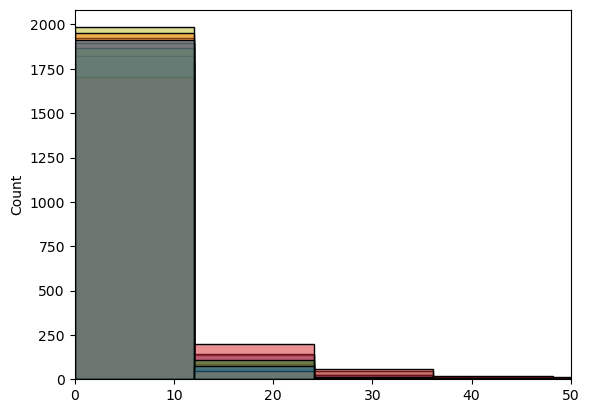

In [128]:
g = sns.histplot(emot_df[:2000], bins=20, common_norm=True, legend=False)
g.set(xlim=(0, 50));

In [49]:
emot_df

,anger,disgust,fear,negative,sadness,anticipation,joy,positive,surprise,trust
0,9.0,5.0,9.0,12.0,7.0,7.0,5.0,5.0,5.0,5.0
1,0.0,1.0,1.0,2.0,0.0,3.0,2.0,3.0,2.0,3.0
2,2.0,2.0,2.0,2.0,1.0,2.0,2.0,3.0,1.0,3.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,21.0,13.0,30.0,40.0,29.0,26.0,9.0,15.0,8.0,13.0
...,...,...,...,...,...,...,...,...,...,...
231302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
231303,1.0,1.0,2.0,2.0,1.0,0.0,1.0,2.0,0.0,2.0
231304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
231305,9.0,6.0,7.0,14.0,10.0,3.0,2.0,7.0,1.0,4.0


In [47]:
1 + (10 + 6 + 10 + 13 + 8 + 8 + 6 + 6 + 6 + 6)

80

# SKIP AND COME BACK POST-EMOTION CLASSIFICATION

### 1.6 - Train-Test Split

* Split Ratio - 80% Train : 10% Val: 10% Test

In [ ]:
df

In [ ]:
X = df["text"]
y = df["target"]

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

In [ ]:
print(f"Size - Train: {len(X_train)}, Val: {len(X_val)}, Test:{len(X_test)}")
print(
    f"Percent - Train: {len(X_train)/len(X)*100:.1f}%, Val: {len(X_val)/len(df)*100:.1f}%, Test:{len(X_test)/len(df)*100:.1f}%"
)

In [ ]:
print(f"Size - Train: {len(y_train)}, Val: {len(y_val)}, Test:{len(y_test)}")
print(
    f"Percent - Train: {len(y_train)/len(y)*100:.1f}%, Val: {len(y_val)/len(df)*100:.1f}%, Test:{len(y_test)/len(df)*100:.1f}%"
)

---

# First Simple Model: Multinomial NB with TF-IDF Vectorizer

### 4. TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=0.10, max_df=0.90)
X_train_vt = vectorizer.fit_transform(X_train)

In [ ]:
X_val_vt = vectorizer.transform(X_val)

In [ ]:
tfidf_tokens = vectorizer.get_feature_names_out()
df_vt = pd.DataFrame(
    data=X_train_vt.toarray(), index=y_train.index, columns=tfidf_tokens
)

In [ ]:
df_vt

In [ ]:
base_nb = MultinomialNB()
model = base_nb.fit(X_train_vt, y_train)

In [ ]:
prior_0 = y_train.value_counts()[0] / len(y_train)
prior_1 = y_train.value_counts()[1] / len(y_train)
prior_0, prior_1

In [ ]:
base_nb.class_log_prior_

In [ ]:
y_pred = base_nb.predict(X_train_vt)
accuracy_score(y_train, y_pred)

In [ ]:
y_hat = base_nb.predict(X_val_vt)
print(accuracy_score(y_val, y_hat))
print(precision_score(y_val, y_hat))
print(recall_score(y_val, y_hat))

In [ ]:
cm = confusion_matrix(y_val, y_hat)
plot_confusion_matrix(cm, classes=["non-risk", "suicide risk"], normalize=True)

In [ ]:
print(classification_report(y_val, y_hat, labels=[0, 1]))

## Summary of First Simple Model

* Seems to be well-fitting model-- not particularly over or under fit (73.6% Train vs. 73.2% Val)
* Accuracy on Validation Data is **73.2%**
* Higher Recall (0.78) than Precision (0.71). The model overestimates suicide risk and minimizes false negatives.
    * This is good: much better to err on the side of caution

---

---

---

### Combine Emotion_DF and X_train

In [ ]:
pd.concat(X_train, emo_df, axis=1, inner,

In [ ]:
emo_X_train = emo_df.merge(X_train, how="right", on="text")

In [ ]:
emo_X_train

In [ ]:
row1 = NRCLex(
    "i am done say it all i am unemotional thought i lost someone i am sucked i can not do this anymore i will never deserve you clothesline basement after chair here we go thanks everyone"
)

In [ ]:
row1_replace = row1.affect_frequencies

In [ ]:
row1_replace = dict(row1_replace)

In [ ]:
row1_replace

In [ ]:
row1_replace.values()

In [ ]:
for key, val in row1_replace.items():
    emo_X_train.at[0, key] = val

In [ ]:
### Come back to df_vt

---

## Sentiment Model #1: Naive Bayes + Affect Frequencies

In [ ]:
emo_X_train.index

In [ ]:
base_nb = MultinomialNB()
model = base_nb.fit(X_train_vt, y_train)

##### Create Corpus and Tokens with Spacy

In [ ]:
# Small X-train, y_train

X_train[:37009].to_csv("./data/small_X_train.csv")
y_train[:37009].to_csv("./data/small_y_train.csv")

In [ ]:
X_train["text"] = X_train["text"].apply(lambda x: str(x))

In [ ]:
nlp.pipe_names

In [ ]:
nlp.add_pipe("spacytextblob")

In [ ]:
off_list = ["parser", "ner"]

for funct in off_list:
    nlp.disable_pipe(funct)

In [ ]:
# ~33 min to run
start = time.time()

texts_tr = X_train["text"][:37009]
docs_tr = list(nlp.pipe(texts_tr, batch_size=1000))

end = time.time()

print(f"Time taken: {(end-start)/60} minutes")